In [1]:
# required imports
import os
from typing import Tuple, Any, Optional
import pandas as pd
import numpy as np
import optuna
from optuna.samplers import TPESampler
from optuna.trial import Trial
from optuna.integration import CatBoostPruningCallback
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, RepeatedKFold
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.utils import shuffle
from catboost import CatBoostRegressor, CatBoostClassifier
import matplotlib.pyplot as plt

In [2]:
# if `use_optuna` is set to False the set of parameters found early with optuna will be used without optimizazion (the fastest solution)
# if `use_optuna` is set to True and `n_jobs` is set to -1 the parallelized hyperparameter optimization with optuna will be performed (the slower solution)
# in this case the optimization is not reproducible
# if `use_optuna` is set to True and `n_jobs` is set to 1 the sequential hyperparameter optimization with optuna will be performed (the slowest solution)
# in this case the optimization is reproducible
use_optuna = False
n_jobs = -1

In [3]:
# set random seed
RANDOM_SEED = 42
random_state = RANDOM_SEED
np.random.seed(RANDOM_SEED)
os.environ["PYTHONHASHSEED"] = str(0)

In [4]:
# load train and test datasets from the script folder
data_path =  "./"
train = pd.read_csv(data_path + "Train.csv")
test = pd.read_csv(data_path + "Test.csv")

In [5]:
# names of numerical columns
NUM_COLS = ["Ganaura", "CropOrgFYM", "BasalDAP", "BasalUrea", "1tdUrea", "2tdUrea"]

# CatBoost supports numerical, categorical, text, and embeddings features
# names of categorical features which go to CatBoost without one-hot encoding
CATEG_COLS = ["District", "Block", "CropEstMethod", "TransplantingIrrigationSource",
              "TransplantingIrrigationPowerSource", "PCropSolidOrgFertAppMethod",
              "MineralFertAppMethod", "MineralFertAppMethod.1", "Harv_method", "Threshing_method", "Stubble_use"]

# names of text features which go to CatBoost without preprocessing 
TEXT_COLS = ["LandPreparationMethod", "NursDetFactor", "TransDetFactor", "OrgFertilizers", "CropbasalFerts", "FirstTopDressFert"]

# these parameters go to CatBoost without any optimization or modification
FIX_PARAMS = {
    "cat_features": CATEG_COLS,
    "text_features": TEXT_COLS,
    "logging_level": "Silent",
    "dictionaries": [
        {"dictionary_id": "BiGram",
         "occurence_lower_bound": 1},
        {"dictionary_id": "Word",
         "occurence_lower_bound": 1}
    ],
    "random_state": random_state
}

In [6]:
def diff_days(df_train: pd.DataFrame, df_test: pd.DataFrame, col1: str, col2: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Calculate number of days between two date columns for train and test DataFrames and add results as a new column.

    Args:
        df_train: train DataFrame
        df_test: test DataFrame
        col1: name of the first date column
        col2: name of the second date column

    Returns:
        Train and test DataFrames with difference column.

    """
    df_train[f"{col1}_{col2}"] = (pd.to_datetime(df_train.loc[:, col1], format="%Y-%m-%d") - pd.to_datetime(df_train.loc[:, col2], format="%Y-%m-%d")).dt.days.astype(np.float32)
    df_test[f"{col1}_{col2}"] = (pd.to_datetime(df_test.loc[:, col1], format="%Y-%m-%d") - pd.to_datetime(df_test.loc[:, col2], format="%Y-%m-%d")).dt.days.astype(np.float32)
    return df_train, df_test

def n_days(df_train: pd.DataFrame, df_test: pd.DataFrame, col: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Calculate number of days between each row in the column of train and test DataFrames
    and minimal date of the same column in the train DataFrame and add results as a new column.

    Args:
        df_train: train DataFrame
        df_test: test DataFrame
        col: name of the date column

    Returns:
        Train and test DataFrames with calculated column.

    """
    min_date = min(pd.to_datetime(df_train.loc[:, col], format="%Y-%m-%d"))
    df_train[f"n_{col}"] = (pd.to_datetime(df_train.loc[:, col], format="%Y-%m-%d") - min_date).dt.days.astype(np.float32)
    df_test[f"n_{col}"] = (pd.to_datetime(df_test.loc[:, col], format="%Y-%m-%d") - min_date).dt.days.astype(np.float32)
    return df_train, df_test

def rmse_scorer(clf: Any, x: pd.DataFrame, y: pd.Series) -> float:
    """Make prediction and calculate RMSE between predicted and true values.

    Args:
        clf: Regressor
        x: DataFrame used for prediction
        y: Series with true values

    Returns:
        RMSE value.

    """
    y_pred = clf.predict(x) * x.loc[:, "Acre"]
    rmse = mean_squared_error(y * x.loc[:, "Acre"], y_pred, squared=False)
    return rmse

def objective(trial: Trial, params: dict, x: pd.DataFrame, y: pd.Series, cv: Any, x_val: Optional[pd.DataFrame] = None, y_val: Optional[pd.Series] = None) -> float:
    """

    Args:
        trial:  process of evaluating an objective function
        params: Dictionary with parameters
        x: training data
        y: target data
        cv: cross-validator
        x_val: validation subset of training data
        y_val: validation subset of target data

    Returns:
        RMSE of the evaluation

    """
    total_test_score = []
    model = CatBoostRegressor(**params)
    trial.set_user_attr(key="best_booster", value=model)
    pruning_callback = CatBoostPruningCallback(trial, "RMSE")
    for i, (train_idx, test_idx) in enumerate(cv.split(x, y)):
        x_train = x.iloc[train_idx, :]
        x_test = x.iloc[test_idx, :]
        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]
        if (x_val is not None) and (y_val is not None):
            model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100)
        else:
            model.fit(x_train, y_train)
        callbacks=[pruning_callback]
        pruning_callback.check_pruned()
        test_score = rmse_scorer(model, x_test, y_test)
        total_test_score.append(test_score)
    return round(np.mean(total_test_score), 6)

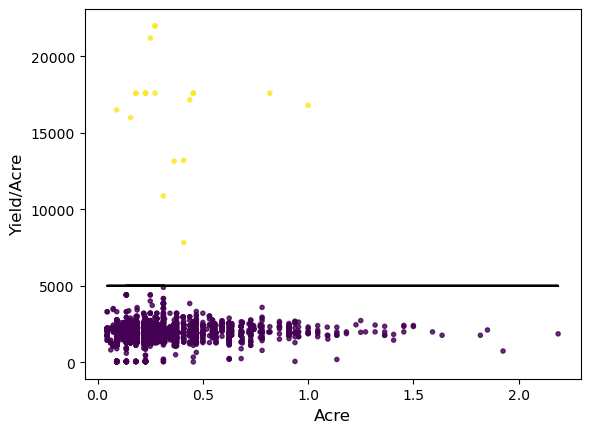

In [7]:
# plot of "Yield" normalized to "Acre" column as a function of the "Acre" column
# there are two distinct groups of instances:
# the instances with the normalized "Yield" values smaller than 5000 (class 0)
# the instances with the normalized "Yield" values larger than 5000 (class 1)
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)
ax1.scatter(train.loc[:, "Acre"],
            train.loc[:, "Yield"] / train.loc[:, "Acre"],
            marker = '.',
            c=(train.loc[:, "Yield"] / train.loc[:, "Acre"]).apply(lambda x: 0 if x <= 5000. else 1), alpha = 0.8)
ax1.plot(train.loc[:, "Acre"], train.loc[:, "Acre"]*0+5000, c="black")
plt.xlabel("Acre", fontsize=12)
plt.ylabel("Yield/Acre", fontsize=12)
plt.show()

In [8]:
# feature engineering

test_id = test.loc[:, "ID"]

# add class 0 or 1 according to the graph above
train.loc[:, "class"] = (train.loc[:, "Yield"]/train.loc[:, "Acre"]).apply(lambda x: 0 if x <= 5000. else 1)

# normalization
train.loc[:, "Yield"] = train.loc[:, "Yield"] / train.loc[:, "Acre"]

# convert date to number of days
train, test = n_days(train, test, "CropTillageDate")
train, test = n_days(train, test, "RcNursEstDate")
train, test = n_days(train, test, "SeedingSowingTransplanting")
train, test = n_days(train, test, "Harv_date")
train, test = n_days(train, test, "Threshing_date")

# calculate difference between date columns
train, test = diff_days(train, test, "SeedingSowingTransplanting", "RcNursEstDate")
train, test = diff_days(train, test, "SeedingSowingTransplanting", "CropTillageDate")
train, test = diff_days(train, test, "Harv_date", "SeedingSowingTransplanting")
train, test = diff_days(train, test, "Threshing_date", "Harv_date")

# calculate difference between "CultLand" and "CropCultLand"
train["CropCultLand_CultLand_Diff"] = train["CultLand"] - train["CropCultLand"]
test["CropCultLand_CultLand_Diff"] = test["CultLand"] - test["CropCultLand"]

# normalize numerical columns to areas
for area_col in ["Acre", "CropCultLand"]:
    for col in NUM_COLS:
        train[f"norm_{col}_{area_col}"] = train[col]/train[area_col]
        test[f"norm_{col}_{area_col}"] = test[col]/test[area_col]

# drop "ID" and all date columns
cols_to_drop = ["ID",
                "CropTillageDate",
                "RcNursEstDate",
                "SeedingSowingTransplanting",
                "Harv_date",
                "Threshing_date"]
train = train.drop(cols_to_drop, axis = 1)
test = test.drop(cols_to_drop, axis = 1)

# replace NaNs with "" in text columns and with "nan" in categorical columns
# no imputing of missing values is required for CatBoost
train.loc[:, TEXT_COLS] = train.loc[:, TEXT_COLS].fillna("")
test.loc[:, TEXT_COLS] = test.loc[:, TEXT_COLS].fillna("")
train.loc[:, CATEG_COLS] = train.loc[:, CATEG_COLS].fillna("nan")
test.loc[:, CATEG_COLS] = test.loc[:, CATEG_COLS].fillna("nan")

In [9]:
# perform classification of test dataset to class 0 or 1 using CatBoostClassifier with grid search for hyperparameter tuning
x = train.drop(["class", "Yield"], axis = 1)
y = train.loc[:, "class"]
x, y = shuffle(x, y, random_state=random_state)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y, random_state=random_state)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
model = CatBoostClassifier(**FIX_PARAMS)
param_grid = {
        "n_estimators": [100, 150, 200, 250, 300]
    }
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    return_train_score=True,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1
).fit(x_train, y_train)
best_estimator = grid_search.best_estimator_
best_score = grid_search.best_score_
y_pred = best_estimator.predict(x_test)
test_score = accuracy_score(y_test, y_pred)
print(grid_search.best_params_, best_score, test_score)
best_estimator.fit(x, y)
pred_class = best_estimator.predict(test)
pred_proba = best_estimator.predict_proba(test)
test.loc[:, "class"] = pred_class

{'n_estimators': 100} 0.9948311472490949 0.9927685950413223


In [10]:
# split train dataset into two parts depending on class 0 or 1
train_0 = train.loc[train["class"] == 0, :]
train_1 = train.loc[train["class"] == 1, :]
x_0 = train_0.drop(["class", "Yield"], axis = 1)
x_1 = train_1.drop(["class", "Yield"], axis = 1)
y_0 = train_0.loc[:, "Yield"]
y_1 = train_1.loc[:, "Yield"]

In [11]:
# create CatBoostRegressor model for the class 0
# if `use_optuna` is set to True the optimal set of parameters will be found using optuna
# otherwise the predefined set of parameters will be used
x_0, x_val, y_0, y_val = train_test_split(x_0, y_0, test_size=0.2, random_state=random_state)

if use_optuna:
    # search for optimal set of parameters with optuna
    cv = KFold(n_splits=6, shuffle=True, random_state=random_state)

    def build_params(trial):
        params_optuna = {
            "learning_rate": trial.suggest_float('learning_rate', 0.01, 0.03),
            "n_estimators": trial.suggest_int("n_estimators", 1000, 3000),
            "depth": trial.suggest_int('depth', 6, 10),
            "l2_leaf_reg": trial.suggest_float('l2_leaf_reg', 0.1, 1.0),
            "colsample_bylevel": trial.suggest_float('colsample_bylevel', 0.1, 1.0),
            "bagging_temperature": trial.suggest_float('bagging_temperature', 0.0, 1.0),
            "border_count": trial.suggest_int('border_count', 32, 255),
            "min_child_samples": trial.suggest_int('min_child_samples', 1, 6)
        }
        params_optuna = params_optuna | FIX_PARAMS
        return params_optuna

    study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), sampler=TPESampler(seed=random_state), direction="minimize")
    study.optimize(func=lambda trial: objective(trial, build_params(trial), x_0, y_0, cv, x_val, y_val), gc_after_trial=True, n_trials=35, n_jobs=n_jobs)
    print("=================================")
    print(study.best_params)
    print(study.best_value)
    params = study.best_params | FIX_PARAMS
else:
    # these parameters were found early with optuna and used to generate submitted solution
    optimal_params = {
        'learning_rate': 0.026319344641368248,
        'n_estimators': 2109,
        'depth': 9,
        'l2_leaf_reg': 0.22469429236870356,
        'colsample_bylevel': 0.5676305196474462,
        'bagging_temperature': 0.011540717467886874,
        'border_count': 246,
        'min_child_samples': 3
    }
    params = optimal_params | FIX_PARAMS
best_model = model = CatBoostRegressor(**params)
best_model.fit(x_0, y_0, eval_set=[(x_val, y_val)], early_stopping_rounds=100)
preds_0 = test.loc[:, "Acre"] * best_model.predict(test.loc[:, x_0.columns])
submission_0 = pd.DataFrame({"ID": test_id, "Yield_0": preds_0})

In [12]:
# create CatBoostRegressor model for the class 1
# if `use_optuna` is set to True the optimal set of parameters will be found using optuna
# otherwise the predefined set of parameters will be used
if use_optuna:
    # search for optimal set of parameters with optuna
    cv = RepeatedKFold(n_splits=6, n_repeats=3, random_state=random_state)

    def build_params(trial):
        params_optuna = {
            "learning_rate": trial.suggest_float('learning_rate', 0.02, 0.2, log=True),
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "depth": trial.suggest_int('depth', 10, 16),
            "l2_leaf_reg": trial.suggest_float('l2_leaf_reg', 0.001, 1.0, log=True),
            "colsample_bylevel": trial.suggest_float('colsample_bylevel', 0.1, 0.3),
            "bagging_temperature": trial.suggest_float('bagging_temperature', 0.0, 0.5),
            "border_count": trial.suggest_int('border_count', 32, 255),
            "min_child_samples": trial.suggest_int('min_child_samples', 30, 60),
            "random_strength": trial.suggest_float('random_strength', 0.5, 1.0),
            "nan_mode": trial.suggest_categorical("nan_mode", ["Min", "Max"]),
        }
        params_optuna = params_optuna | FIX_PARAMS
        return params_optuna

    study = optuna.create_study(sampler=TPESampler(seed=random_state), direction="minimize")
    study.optimize(func=lambda trial: objective(trial, build_params(trial), x_1, y_1, cv), gc_after_trial=True, n_trials=30, n_jobs=-1)
    print("=================================")
    print(study.best_params)
    print(study.best_value)
    params = study.best_params | FIX_PARAMS
else:
    # these parameters were found early with optuna and used to generate submitted solution
    optimal_params = {
        'learning_rate': 0.06662603766388486,
        'n_estimators': 229,
        'depth': 15,
        'l2_leaf_reg': 0.0025278338803603187,
        'colsample_bylevel': 0.22788311999825814,
        'bagging_temperature': 0.2298011460426364,
        'border_count': 84,
        'min_child_samples': 39,
        'random_strength': 0.7393804643512268,
        'nan_mode': 'Max'
    }
    params = optimal_params | FIX_PARAMS
best_model = CatBoostRegressor(**params)
best_model.fit(x_1, y_1)
preds_1 = test.loc[:, "Acre"] * best_model.predict(test.loc[:, x_1.columns])
submission_1 = pd.DataFrame({"Yield_1": preds_1})

In [13]:
# combine predictions for class 0 and class 1 together
submission = pd.concat([submission_0, submission_1, test.loc[:, ["class"]]], axis=1)
submission.loc[:, "Yield"] = np.where(submission.loc[:, "class"], submission.loc[:, "Yield_1"], submission.loc[:, "Yield_0"])
# select only required columns for the submission
submission = submission.loc[:, ["ID", "Yield"]]
# save submission to the file
submission.to_csv("submission_class01_5.csv", index = False)
submission

,ID,Yield
0,ID_F9XXEXN2ADR2,613.542711
1,ID_SO3VW2X4QO93,430.260176
2,ID_UKUQ7JM8E894,443.527754
3,ID_QUISMWEZR2H4,311.983277
4,ID_25JGI455VKCZ,545.276215
...,...,...
1285,ID_6MMECMX3B728,1186.186438
1286,ID_GZ9YGWCLLMKN,434.856241
1287,ID_01YVA2LJVYBR,209.319238
1288,ID_YQRL2IOUU4SZ,381.492718
